In [1]:
import torch
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm
from tqdm import tqdm

In [2]:
N = 100
x = np.linspace(-10, 10, N).reshape(-1, 1)

mu, sigma = 0, 2
rv = norm(mu, sigma)
p = rv.pdf

In [3]:
def h(x):
    return 2 * x

In [4]:
hx_bar = (h(x) * p(x)).mean()
hx_bar

-1.5204749622983043e-18

In [5]:
def phi(x):
    return sigma**2 * h(x)

Text(0, 0.5, '$\\phi(x)$')

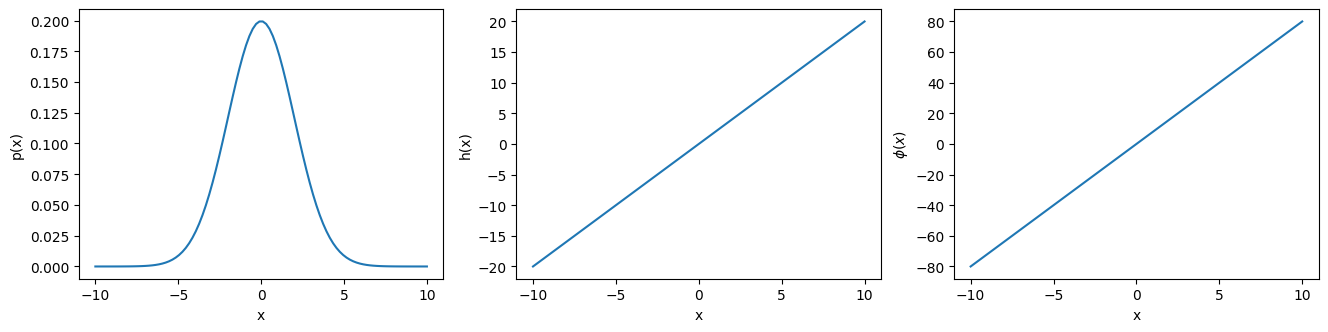

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(16, 3.5))
ax[0].plot(x, p(x))
ax[0].set_xlabel('x')
ax[0].set_ylabel('p(x)')

ax[1].plot(x, h(x))
ax[1].set_xlabel('x')
ax[1].set_ylabel('h(x)')


ax[2].plot(x, phi(x))
ax[2].set_xlabel('x')
ax[2].set_ylabel('$\phi(x)$')

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [8]:
def dm(X, h, ϕ_prev, ϵ=0.01, L=1000):
    
    X_1, X_2 = torch.meshgrid(X, X, indexing='ij')
    g = torch.exp(-torch.square(X_1 - X_2)/(4*ϵ))

    g_rowsum = torch.sum(g, axis=1)
    g_1, g_2 = torch.meshgrid(g_rowsum, g_rowsum, indexing='ij')
    k = g/(torch.sqrt(g_1)*torch.sqrt(g_2))

    d = torch.sum(k, axis=1)
    T = k/d[:, None]
    π = d/d.sum()

    hx_hat = torch.sum(π*h(X))

    ϕ = ϕ_prev

    for t in tqdm(range(1, L+1)):
        ϕ = (T * ϕ).sum(axis=1) + ϵ*(h(X) - hx_hat)
    
    return ϕ

In [12]:
m = 4
N_list = np.geomspace(1000, 16000, m).astype('int')
L_list = [1000, 10000]
N_list

array([ 1000,  2519,  6349, 16000])

100%|██████████| 1000/1000 [00:00<00:00, 20430.72it/s]


N: 1000 Error: 1.0119


100%|██████████| 1000/1000 [00:00<00:00, 10240.03it/s]


N: 2519 Error: 1.3144


100%|██████████| 1000/1000 [00:00<00:00, 1926.10it/s]


N: 6349 Error: 0.8883


100%|██████████| 1000/1000 [00:03<00:00, 320.42it/s]


N: 16000 Error: 0.9510


100%|██████████| 10000/10000 [00:00<00:00, 20472.61it/s]


N: 1000 Error: 3.7778


100%|██████████| 10000/10000 [00:01<00:00, 8873.98it/s]


N: 2519 Error: 2.1849


100%|██████████| 10000/10000 [00:06<00:00, 1637.41it/s]


N: 6349 Error: 0.9436


100%|██████████| 10000/10000 [00:36<00:00, 272.65it/s]


N: 16000 Error: 0.4541


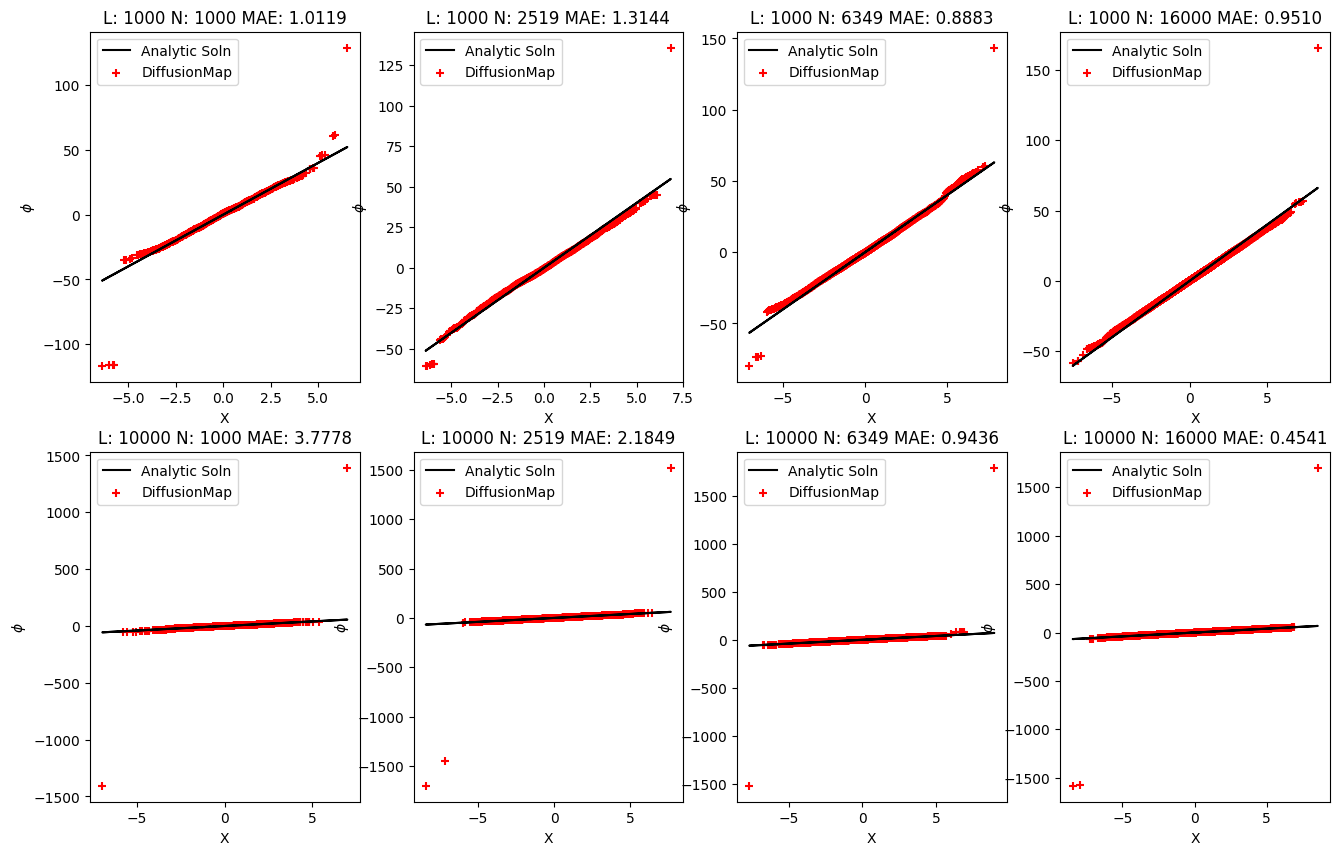

In [13]:
fig, ax = plt.subplots(2, m, figsize=(16, 10))

for i, L in enumerate(L_list):
    for j, N in enumerate(N_list):
        X = torch.normal(mu * torch.ones(N), sigma * torch.ones(N)).to(device)
        ϕ_pred = dm(X, h, torch.randn(len(X)).to(device), L=L)
        error = F.l1_loss(ϕ_pred, phi(X)).item()
        print(f"N: {N} Error: {error:.4f}")
        
        X_cpu = X.cpu().numpy()
        ax[i, j%m].plot(X_cpu, phi(X_cpu), color='black', linewidth=1.5, label='Analytic Soln')
        ax[i, j%m].scatter(X_cpu, ϕ_pred.cpu().numpy(), color='red', marker='+', label='DiffusionMap')
        ax[i, j%m].set_xlabel('X')
        ax[i, j%m].set_ylabel('$\phi$')
        ax[i, j%m].legend()
        ax[i, j%m].set_title(f"L: {L} N: {N} MAE: {error:.4f}")

fig.savefig('filtering.png')